# User Guide

## Geometries on a map: `GeoVector`

In [1]:
import telluric as tl
from telluric.constants import WGS84_CRS, WEB_MERCATOR_CRS

The simplest geometrical element in telluric is the [GeoVector](http://telluric.readthedocs.io/en/latest/api.html#telluric.vectors.GeoVector): it represents a shape in some coordinate reference system (CRS). The easiest way to create one is to use the `GeoVector.from_bounds` method:

In [2]:
gv1 = tl.GeoVector.from_bounds(
    xmin=0, ymin=40, xmax=1, ymax=41, crs=WGS84_CRS
)
print(gv1)

GeoVector(shape=POLYGON ((0 40, 0 41, 1 41, 1 40, 0 40)), crs=CRS({'init': 'epsg:4326'}))


If we print the object, we see its two defining elements: a shape (actually a shapely `BaseGeometry` object) and a CRS (in this case WGS84 or http://epsg.io/4326). Rather than reading a dull representation, we can directly visualize it in the notebook:

/home/juanlu/Satellogic/telluric/telluric/plotting.py:141: UserWarning: Plotting a limited representation of the data, use the .plot() method for further customization
  "Plotting a limited representation of the data, use the .plot() method for further customization")


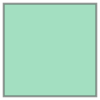

In [3]:
gv1

<div class="alert alert-info">You can ignore the warning for the moment. Advanced plotting techniques are not yet covered in this User Guide. </div>

As you can see, we have an interactive Web Mercator map where we can display our shape. We can create more complex objects using the [Shapely](http://shapely.readthedocs.io/en/stable/manual.html) library:

In [4]:
from shapely.geometry import Polygon

gv2 = tl.GeoVector(
    Polygon([(0, 40), (1, 40.1), (1, 41), (-0.5, 40.5), (0, 40)]),
    WGS84_CRS
)
print(gv2)

GeoVector(shape=POLYGON ((0 40, 1 40.1, 1 41, -0.5 40.5, 0 40)), crs=CRS({'init': 'epsg:4326'}))


And we can access any property of the underlying geometry using the same attribute name:

In [5]:
print(gv1.centroid)

GeoVector(shape=POINT (0.5 40.5), crs=CRS({'init': 'epsg:4326'}))


In [6]:
gv1.area  # Real area in square meters

9422706289.175217

In [7]:
gv1.is_valid

True

In [8]:
gv1.within(gv2)

False

/home/juanlu/Satellogic/telluric/telluric/plotting.py:141: UserWarning: Plotting a limited representation of the data, use the .plot() method for further customization
  "Plotting a limited representation of the data, use the .plot() method for further customization")


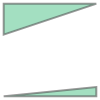

In [9]:
gv1.difference(gv2)

## Geometries with attributes: `GeoFeature` and `FeatureCollection`

The next object in the telluric hierarchy is the [GeoFeature](http://telluric.readthedocs.io/en/latest/api.html#telluric.features.GeoFeature): a combination of a `GeoVector` + some attributes. These attributes can represent land use, types of buildings, and so forth.

In [10]:
gf1 = tl.GeoFeature(
    gv1,
    {'name': 'One feature'}
)
gf2 = tl.GeoFeature(
    gv2,
    {'name': 'Another feature'}
)
print(gf1)
print(gf2)

GeoFeature(Polygon, {'name': 'One feature'})
GeoFeature(Polygon, {'name': 'Another feature'})


But the most interesting thing is to combine these features into a [FeatureCollection](http://telluric.readthedocs.io/en/latest/api.html#telluric.collections.FeatureCollection). A `FeatureCollection` is essentially a sequence of features, with some additional methods:

In [11]:
fc = tl.FeatureCollection([gf1, gf2])
fc

/home/juanlu/Satellogic/telluric/telluric/plotting.py:141: UserWarning: Plotting a limited representation of the data, use the .plot() method for further customization
  "Plotting a limited representation of the data, use the .plot() method for further customization")


In [12]:
print(fc.convex_hull)

GeoVector(shape=POLYGON ((0 40, -0.5 40.5, 0 41, 1 41, 1 40, 0 40)), crs=CRS({'init': 'epsg:4326'}))


In [13]:
print(fc.envelope)

GeoVector(shape=POLYGON ((-0.5 40, 1 40, 1 41, -0.5 41, -0.5 40)), crs=CRS({'init': 'epsg:4326'}))


## Input and Output

Apart from all the previous geospatial operations, we can also save these `FeatureCollection` objects to disk, for example using the GeoJSON or ESRI Shapefile formats:

In [14]:
fc.save("test_fc.shp")

In [15]:
!ls test_fc*

test_fc.cpg  test_fc.dbf  test_fc.json	test_fc.prj  test_fc.shp  test_fc.shx


In [16]:
fc.save("test_fc.json")

In [17]:
!python -m json.tool < test_fc.json | head -n28

{
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {
            "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
        }
    },
    "features": [
        {
            "type": "Feature",
            "properties": {
                "name": "One feature",
                "highlight": {},
                "style": {}
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            0.0,
                            40.0
                        ],
                        [
                            0.0,
                            41.0
                        ],


To retrieve this data from disk again, we can use another object, `FileCollection`, which behaves in the same way as a `FeatureCollection` but does some smart optimizations so the files are not read completely into memory:

In [18]:
print(list(tl.FileCollection.open("test_fc.shp")))

[GeoFeature(Polygon, {'name': 'One feature', 'highlight': '{}', 'style': '{}'}), GeoFeature(Polygon, {'name': 'Another feature', 'highlight': '{}', 'style': '{}'})]


## Raster data: `GeoRaster2`

After reviewing how to read, manipulate and write vector data, we can use [GeoRaster2](http://telluric.readthedocs.io/en/latest/api.html#telluric.georaster.GeoRaster2) to do the same thing with raster data. `GeoRaster2` will read the raster lazily so we only retrieve the information that we need.

In [19]:
# This will only save the URL in memory
rs = tl.GeoRaster2.open(
    "https://github.com/mapbox/rasterio/raw/master/tests/data/rgb_deflate.tif"
)

# These calls will fecth some GeoTIFF metadata
# without reading the whole image
print(rs.crs)
print(rs.footprint())
print(rs.band_names)

CRS({'init': 'epsg:32618'})
GeoVector(shape=POLYGON ((101984.9999999127 2826915, 339314.9999997905 2826915, 339314.9999998778 2611485, 101985.0000002096 2611485, 101984.9999999127 2826915)), crs=CRS({'init': 'epsg:32618'}))
[0, 1, 2]


`GeoRaster2` also displays itself automatically:

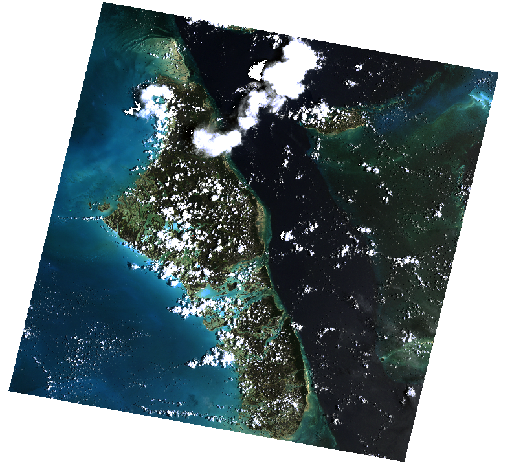

In [20]:
rs

We can slice it like an array, or cropping some parts to discard others:

In [21]:
rs.shape

(3, 718, 791)

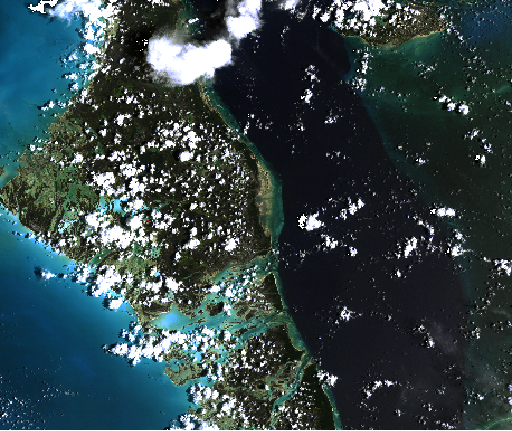

In [22]:
rs.crop(rs.footprint().buffer(-50000))

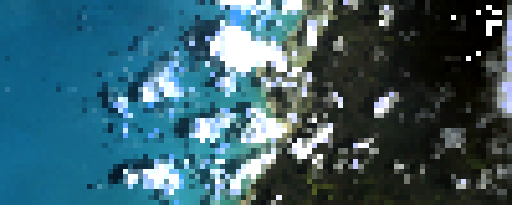

In [23]:
rs[200:300, 200:240]

And save again to GeoTIFF format using a variety of options:

In [24]:
rs[200:300, 200:240].save("test_raster.tif")

## Conclusion

There are many things not covered in this User Guide. The documentation of telluric is a work in progress, so we encourage you to [read the full API reference](http://telluric.readthedocs.io/en/latest/api.html) and even [contribute to the package](http://github.com/satellogic/telluric/)!